In [68]:
using Einsum
using Random
using LinearAlgebra
using Plots
using STFT
using WAV

In [152]:
function ×₃(T::Array{Float64, 3}, v::Vector{Float64})
    @einsum M[i,j] := T[i,j,k]*v[k] #contract the 3rd index of a tensor with a vector
    return M
end

×₃ (generic function with 1 method)

In [189]:
function mu_gnmf(X, T; maxiter=800, tol=5e-4, λ=0, ϵ=1e-8) #multipicative updated nonnegative matrix factorization
    #using LinearAlgebra
    
    # Initilization
    m, n = size(X)
    r, N, p = size(T)
    @assert n==N "Missmatch between the second dimention of X and T"
    A = abs.(randn((m, r)))
    b = abs.(randn((p,)))
    i = 0

    # Updates
    while (norm(X - A*(T×₃b))/norm(X) > tol) && (i < maxiter)
        i += 1
        #@show i
        #@einsum b[q] = b[q] * T[u,v,q]*A[w,u]*X[w,v] / (T[i,j,q]*A[l,i]*A[l,s]*T[s,j,t]*b[t] + ϵ + λ*b[q]) #(W'*V ) ./ (W'*W*H  .+ ϵ + λ.*H) #update b
        #b_old = b
        for q ∈ 1:p
            TT = T[:,:,q]
            b[q] *= tr(TT'*A'*X) / (tr(TT'*A'*A*(T×₃b)) + ϵ + λ*b[q]) #can replace b with b_old?
        end
        B = (T×₃b)
        A .*= (X *B') ./ (A *B*B' .+ ϵ + λ.*A) #update A
    end

    return (A, b, i)
end

mu_gnmf (generic function with 1 method)

In [244]:
function envelope(t, delay; ϵ = 0)
    #ϵ = 1e-4 #prevent divide by zero errors
    d=delay
    a = 0.01 #attack or onset duration
    s = 0.35 #note duration aka sustain
    r = 0.1  #release or offset duration
    A = @. -exp(-a)/a * (t-d) * (t >= d) * (t <= d+a)
    S = @. exp(-(t - d)) * (t >= d+a) * (t <= d+s)
    R = @. -exp(-s)/r * (t-s-d-r) * (t >= d+s) * (t <= d+s+r)
    env = A + S + R
    return @. env + (ϵ * (t < d))
end

# ensures amplitude normalization in slightly under 1 to avoid speaker clipping issues
normalized(y; ceiling = 0.98) =  y ./ maximum(abs.(y)) .* ceiling

normalized (generic function with 1 method)

In [72]:
"""
Time points t, the pitch is the fundimental frequency, harmonics is a list giving the relative weights of each harmonic 
"""
function note(t, pitch, harmonics)
    f₀ = pitch
    ϕ = 0 #global phase shift
    y = sum(b .* sin.(2π*f₀*t*n .+ ϕ) for (n, b) ∈ enumerate(harmonics))
    return normalized(y)
end

note

In [66]:
function hann(N::Int)
    N = N - N % 2 #makes sure N even
    n = 0:N
    return @. sin(π*n/N)^2
end

hann (generic function with 1 method)

In [125]:
# Generate notes for fake data set
sample_rate = 44000. / 16. # 16th reduction from typical sample rate
t = range(0, 1.5, step=1/sample_rate)

# STFT Parameters
w = 250         # window width
hop = w÷2 - 1   # number of samples to hop over
window = hann(w)
nq = sample_rate÷2 #Niquist rate
tmax = maximum(t)

# Notes to be played, major triad has ratio 2:3:5
notes = [100, 150, 250] #Hz

# Matrix Sizes
F, T = size(stft(t, window, hop))
r = length(notes)
freqs = range(0, nq, F)
times = range(0, tmax, T)

0.0:0.05:1.5

In [296]:
#S = 10   # of time-shifts
J = 2316 # of frequencies
K = 2    # of sources
L = 52 #88  # of pitches
N = 8  # of harmonics
#i = 1:S
j = 1:F #j = 1:J
l = 1:L
n = 1:N

1:8

In [271]:
h = n #multiple of the fundimental for the n'th harmonic
b1 = @. 1/n
b2 = @. 1/n^3
b2[3] = 1/2;

In [297]:
f = @. 440*2^((l-49)/12) #pitch of the l'th piano note
#ν = @. 440*2^((j-961)/240) #frequency j for the typical range of human hearing, spacing every 20 cents
ν = freqs #linearly spaced frequencies in Fourier domain

"""
# Examples
notename_to_keynumber("A4") = 49
notename_to_keynumber("B4") = 51
notename_to_keynumber("A#4") = 50
notename_to_keynumber("A♯4") = 50
notename_to_keynumber("Bb4") = 50
notename_to_keynumber("B♭4") = 50

"""
function notename_to_keynumber(s::String) #TODO convert this to a type?
    accidental = " "

    letters = "C D EF G A B" #spaces are for accidentals

    if length(s) == 2
        letter, octave = s
    elseif length(s) == 3
        letter, accidental, octave = s
        if !occursin(accidental,"#♯b♭")
            throw(ArgumentError("Invalid accidental symbol \"$accidental\""))
        end
    else
        throw(ArgumentError("length of s must be 2 or 3"))
    end

    if !occursin(letter,letters)
        throw(ArgumentError("Invalid letter name \"$letter\""))
    end

    offset = 9 # since A0 needs to return 1
    key = 12*parse(Int, octave) + findfirst(letter, letters) - offset

    if occursin(accidental, "#♯")
        key += 1
    elseif occursin(accidental, "b♭")
        key -= 1
    end
    
    return key
end

notename_to_frequency(s::String) = f[notename_to_keynumber(s)]

notename_to_frequency (generic function with 1 method)

In [272]:
source1_notes = ["C3", "D3", "E3"]
source2_notes = ["G3", "F3", "G3"]
source1_delays = [0, 0.4, 0.8] #seconds
source2_delays = [0.2, 0.4, 1] #seconds

x1_heldnotes = [note(t, pitch, b1) for pitch ∈ notename_to_frequency.(source1_notes)]
x2_heldnotes = [note(t, pitch, b2) for pitch ∈ notename_to_frequency.(source2_notes)]

x1_envelopes = [envelope(t, delay) for delay ∈ source1_delays]
x2_envelopes = [envelope(t, delay) for delay ∈ source2_delays]

x1 = 0.8*normalized(sum(nt .* env for (nt, env) ∈ zip(x1_heldnotes, x1_envelopes)))
x2 = normalized(sum(nt .* env for (nt, env) ∈ zip(x2_heldnotes, x2_envelopes)))

y = x1 + x2;

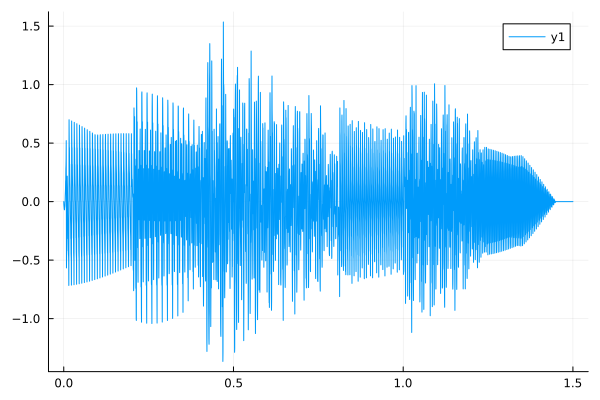

In [273]:
plot(t,y)

In [276]:
wavplay(x1, sample_rate)

In [301]:
function close_in_cents(f,g;tol=20) #within tol cents
	#f_cents = 1200*log2(f/440)
	#g_cents = 1200*log2(g/440)
	#return abs(f_cents - g_cents) < tol
	return 1200*abs(log2(f/g)) < tol #1200 cents per octave (power of 2)
end

function close_in_frequency(f,g;tol=15) #within tol Hz
	return abs(f-g) < tol #1200 cents per octave (power of 2)
end

@einsum D[l,j,n] := close_in_frequency(h[n]*f[l], ν[j]);

In [241]:
Y = abs.(stft(y, window, hop))
Xs = [abs.(stft(x, window, hop)) for x ∈ [x1, x2]];

In [137]:
size(Y)

(126, 31)

In [328]:
D1 = cat(D,0 .* D,dims=3);
D2 = cat(0 .* D,D,dims=3);
DDDD = cat(D1,D2,dims=1);

In [327]:
size(DDDD)

(104, 126, 16)

In [319]:
count(DDDD.==1)

1862

In [192]:
δ = 1e-1
safe_log10(x) = log10(x/δ + 1)
safe_ilog10(x) = (exp10(x) - 1) * δ

safe_ilog10 (generic function with 1 method)

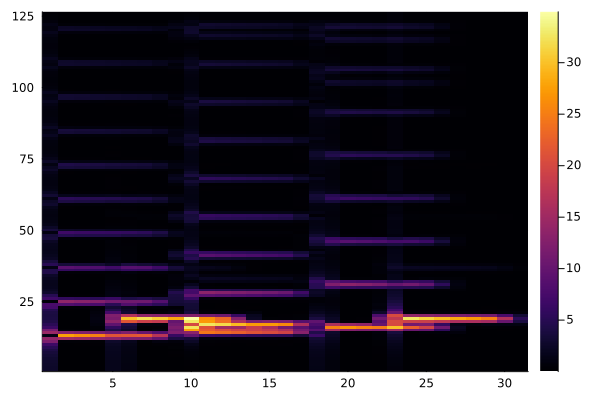

In [242]:
heatmap(Y)

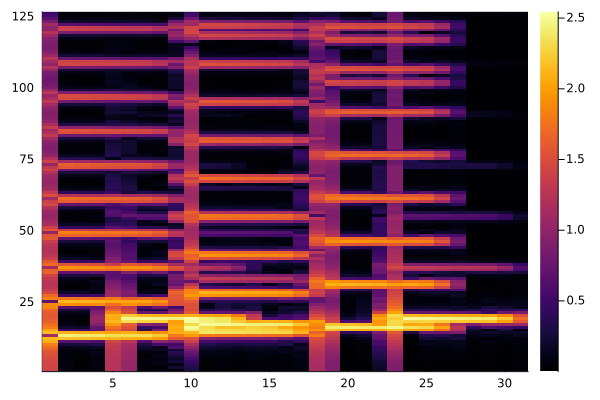

In [243]:
heatmap(safe_log10.(Y))

In [329]:
(AA, bb, i) = mu_gnmf(safe_log10.(Y'), DDDD, maxiter=500)
b1_estimate,b2_estimate = bb[1:N], bb[N+1:end]
A1_estimate,A2_estimate = AA[:, 1:L], AA[:, L+1:end];

In [337]:
size(AA)

(31, 104)

In [330]:
X1_estimate, X2_estimate = safe_ilog10.(A1_estimate*(D×₃b1_estimate))', safe_ilog10.(A2_estimate*(D×₃b2_estimate))';

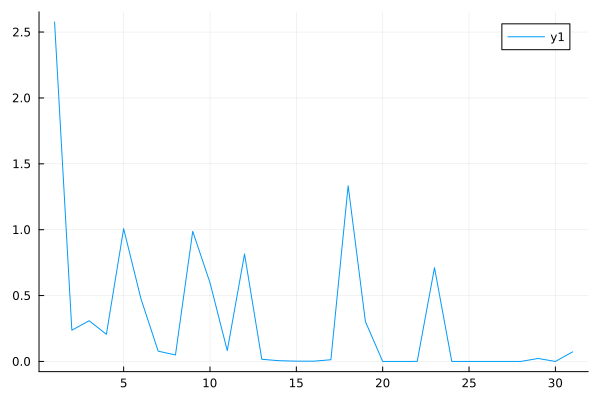

In [322]:
plot(A1_estimate[:,5])

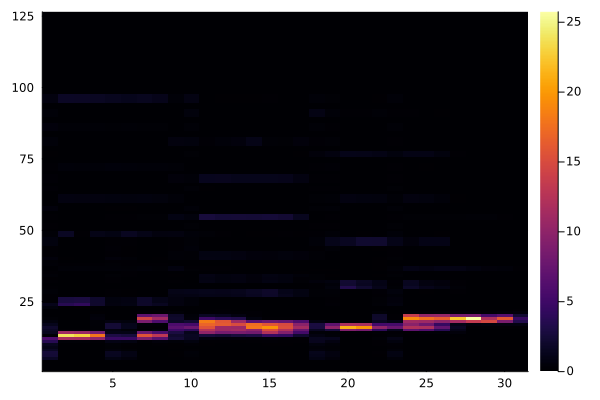

In [331]:
heatmap((X1_estimate))

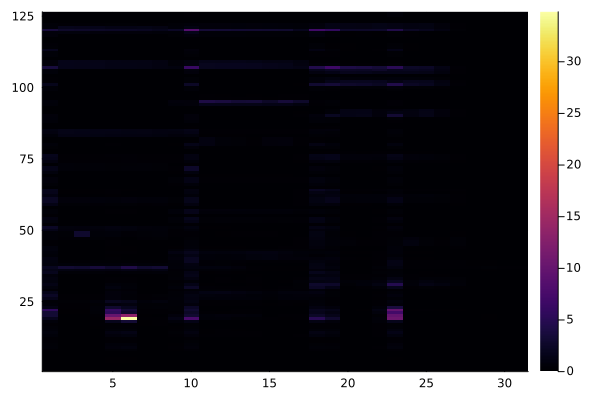

In [332]:
heatmap(X2_estimate)

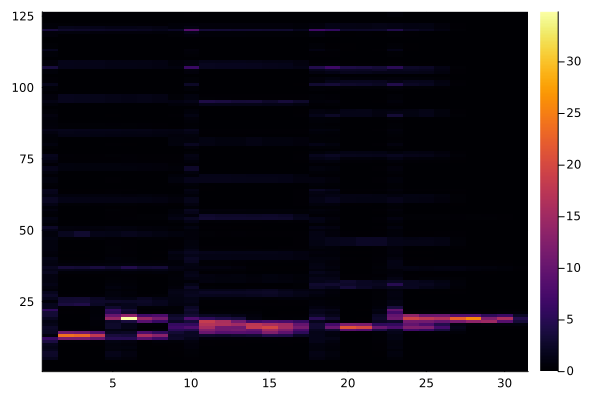

In [333]:
heatmap(X1_estimate + X2_estimate)

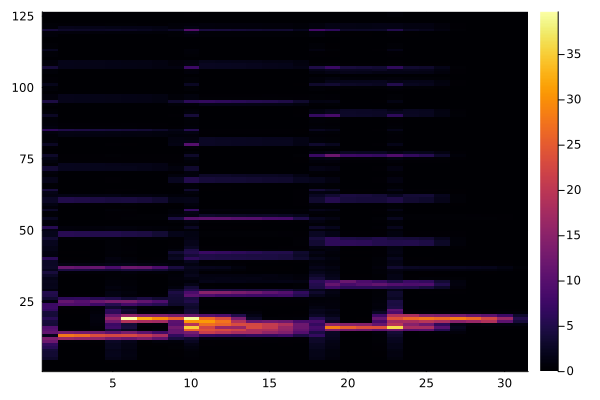

In [335]:
heatmap(safe_ilog10.(AA*(DDDD×₃bb))')

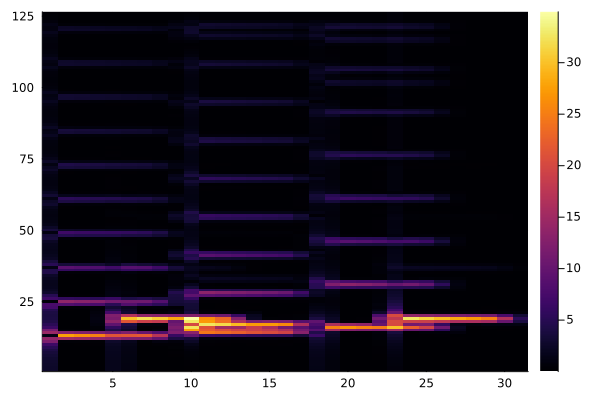

In [336]:
heatmap(Y)